<a href="https://colab.research.google.com/github/samruddhi-2709/Pneumonia-Classification-on-TPU/blob/main/Pneumonia_Classification_on_TPU_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import re
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
    print("TPU initialized.")
except Exception as e:
    print("Failed to initialize TPU:", str(e))
    strategy = tf.distribute.get_strategy()  # Default strategy with CPU or single GPU
print("Number of replicas:", strategy.num_replicas_in_sync)

TPU initialized.
Number of replicas: 8


In [2]:
AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 25 * strategy.num_replicas_in_sync
IMAGE_SIZE = [180, 180]
CLASS_NAMES = ["NORMAL", "PNEUMONIA"]


LOAD THE DATA


In [3]:
train_images = tf.data.TFRecordDataset(
    "gs://download.tensorflow.org/data/ChestXRay2017/train/images.tfrec"
)
train_paths = tf.data.TFRecordDataset(
    "gs://download.tensorflow.org/data/ChestXRay2017/train/paths.tfrec"
)

ds = tf.data.Dataset.zip((train_images, train_paths))

In [4]:
COUNT_NORMAL = len(
    [
        filename
        for filename in train_paths
        if "NORMAL" in filename.numpy().decode("utf-8")
    ]
)
print("Normal images count in training set: " + str(COUNT_NORMAL))

COUNT_PNEUMONIA = len(
    [
        filename
        for filename in train_paths
        if "PNEUMONIA" in filename.numpy().decode("utf-8")
    ]
)
print("Pneumonia images count in training set: " + str(COUNT_PNEUMONIA))

Normal images count in training set: 1349
Pneumonia images count in training set: 3883


In [5]:
def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, "/")
    # The second to last is the class-directory
    if parts[-2] == "PNEUMONIA":
        return 1
    else:
        return 0


def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=3)
    # resize the image to the desired size.
    return tf.image.resize(img, IMAGE_SIZE)


def process_path(image, path):
    label = get_label(path)
    # load the raw data from the file as a string
    img = decode_img(image)
    return img, label


ds = ds.map(process_path, num_parallel_calls=AUTOTUNE)

SPLITTING OF DATA

In [6]:
ds = ds.shuffle(10000)
train_ds = ds.take(4200)
val_ds = ds.skip(4200)

VISUALIZE THE SHAPE OF IMAGE,LABEL

In [7]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  1


LOAD AND FORMAT THE TEST DATA

In [8]:
test_images = tf.data.TFRecordDataset(
    "gs://download.tensorflow.org/data/ChestXRay2017/test/images.tfrec"
)
test_paths = tf.data.TFRecordDataset(
    "gs://download.tensorflow.org/data/ChestXRay2017/test/paths.tfrec"
)
test_ds = tf.data.Dataset.zip((test_images, test_paths))

test_ds = test_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

VISUALIZE THE DATA

In [9]:
def prepare_for_training(ds, cache=True):
    # This is a small dataset, only load it once, and keep it in memory.
    # use `.cache(filename)` to cache preprocessing work for datasets that don't
    # fit in memory.
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()

    ds = ds.batch(BATCH_SIZE)

    # `prefetch` lets the dataset fetch batches in the background while the model
    # is training.
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

In [10]:
train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

image_batch, label_batch = next(iter(train_ds))

In [11]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10, 10))
    for n in range(25):
        ax = plt.subplot(5, 5, n + 1)
        plt.imshow(image_batch[n] / 255)
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

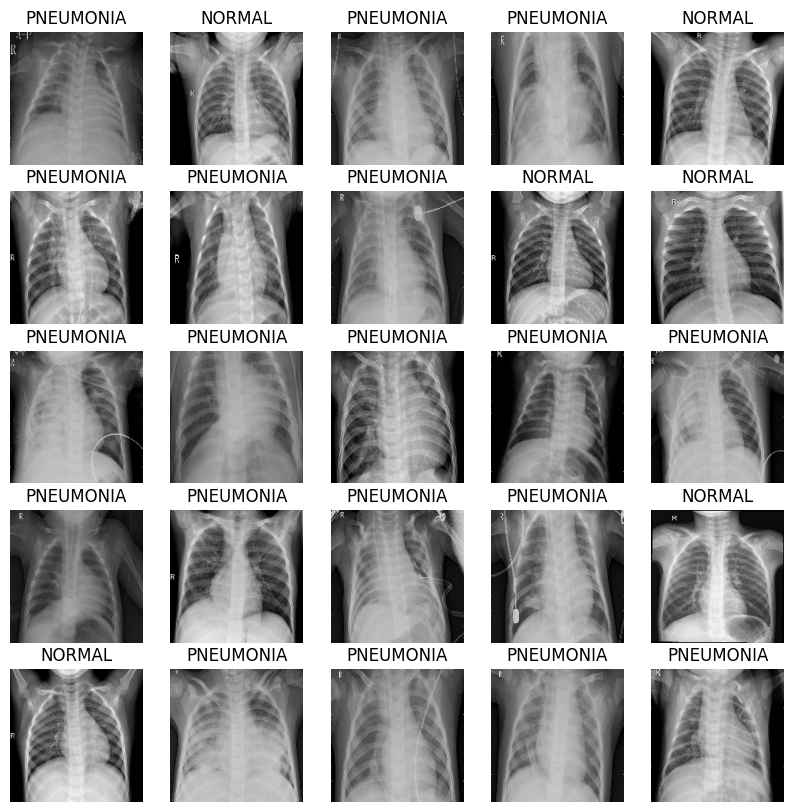

In [12]:
show_batch(image_batch.numpy(), label_batch.numpy())

BUILD THE CNN

In [13]:
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'

import keras
from keras import layers

def conv_block(filters, inputs):
    x = layers.SeparableConv2D(filters, 3, activation="relu", padding="same")(inputs)
    x = layers.SeparableConv2D(filters, 3, activation="relu", padding="same")(x)
    x = layers.BatchNormalization()(x)
    outputs = layers.MaxPool2D()(x)

    return outputs


def dense_block(units, dropout_rate, inputs):
    x = layers.Dense(units, activation="relu")(inputs)
    x = layers.BatchNormalization()(x)
    outputs = layers.Dropout(dropout_rate)(x)

    return outputs

In [14]:
def build_model():
    inputs = keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(16, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(16, 3, activation="relu", padding="same")(x)
    x = layers.MaxPool2D()(x)

    x = conv_block(32, x)
    x = conv_block(64, x)

    x = conv_block(128, x)
    x = layers.Dropout(0.2)(x)

    x = conv_block(256, x)
    x = layers.Dropout(0.2)(x)

    x = layers.Flatten()(x)
    x = dense_block(512, 0.7, x)
    x = dense_block(128, 0.5, x)
    x = dense_block(64, 0.3, x)

    outputs = layers.Dense(1, activation="sigmoid")(x)

    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

CORRECT THE DATA IMBALANCE

In [15]:
initial_bias = np.log([COUNT_PNEUMONIA / COUNT_NORMAL])
print("Initial bias: {:.5f}".format(initial_bias[0]))

TRAIN_IMG_COUNT = COUNT_NORMAL + COUNT_PNEUMONIA
weight_for_0 = (1 / COUNT_NORMAL) * (TRAIN_IMG_COUNT) / 2.0
weight_for_1 = (1 / COUNT_PNEUMONIA) * (TRAIN_IMG_COUNT) / 2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print("Weight for class 0: {:.2f}".format(weight_for_0))
print("Weight for class 1: {:.2f}".format(weight_for_1))

Initial bias: 1.05724
Weight for class 0: 1.94
Weight for class 1: 0.67


TRAIN THE MODEL

In [16]:
checkpoint_cb = keras.callbacks.ModelCheckpoint("xray_model.keras", save_best_only=True)

early_stopping_cb = keras.callbacks.EarlyStopping(
    patience=10, restore_best_weights=True
)

In [17]:
initial_learning_rate = 0.015
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)

In [18]:
with strategy.scope():
    model = build_model()

    METRICS = [
        keras.metrics.BinaryAccuracy(),
        keras.metrics.Precision(name="precision"),
        keras.metrics.Recall(name="recall"),
    ]
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
        loss="binary_crossentropy",
        metrics=METRICS,
    )

history = model.fit(
    train_ds,
    epochs=100,
    validation_data=val_ds,
    class_weight=class_weight,
    callbacks=[checkpoint_cb, early_stopping_cb],
)

Epoch 1/100
21/21 [==============================] - 36s 566ms/step - loss: 0.6192 - binary_accuracy: 0.6776 - precision: 0.8904 - recall: 0.6434 - val_loss: 0.6110 - val_binary_accuracy: 0.7277 - val_precision: 0.7423 - val_recall: 0.9714
Epoch 2/100
21/21 [==============================] - 3s 152ms/step - loss: 0.2672 - binary_accuracy: 0.8902 - precision: 0.9610 - recall: 0.8877 - val_loss: 8.0783 - val_binary_accuracy: 0.2568 - val_precision: 1.0000 - val_recall: 0.0013
Epoch 3/100
21/21 [==============================] - 3s 152ms/step - loss: 0.2192 - binary_accuracy: 0.9157 - precision: 0.9725 - recall: 0.9118 - val_loss: 1.7593 - val_binary_accuracy: 0.3934 - val_precision: 1.0000 - val_recall: 0.1849
Epoch 4/100
21/21 [==============================] - 3s 152ms/step - loss: 0.1764 - binary_accuracy: 0.9307 - precision: 0.9776 - recall: 0.9276 - val_loss: 2.4781 - val_binary_accuracy: 0.4506 - val_precision: 1.0000 - val_recall: 0.2617
Epoch 5/100
21/21 [========================

VISUALIZING MODEL PERFORMANCE

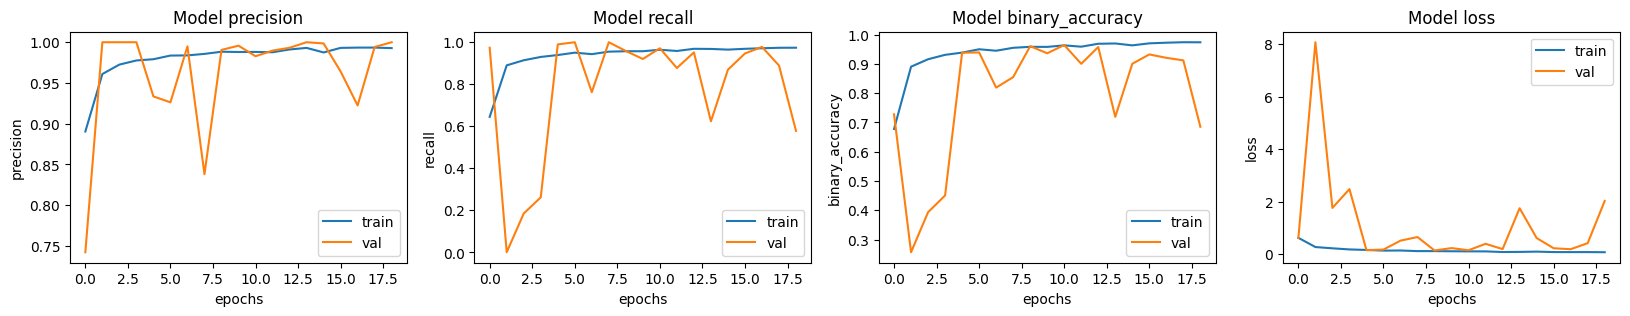

In [19]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(["precision", "recall", "binary_accuracy", "loss"]):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history["val_" + met])
    ax[i].set_title("Model {}".format(met))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(met)
    ax[i].legend(["train", "val"])

PREDICT AND EVALUATE RESULTS

In [20]:
model.evaluate(test_ds, return_dict=True)

4/4 [==============================] - 6s 1s/step - loss: 0.5849 - binary_accuracy: 0.8606 - precision: 0.8389 - recall: 0.9615


{'loss': 0.5849332213401794,
 'binary_accuracy': 0.8605769276618958,
 'precision': 0.8389261960983276,
 'recall': 0.9615384340286255}

1/1 [==============================] - 6s 6s/step
This image is 98.84 percent NORMAL
This image is 1.16 percent PNEUMONIA


<ipython-input-21-d4c28b2be0ce>:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("This image is %.2f percent %s" % ((100 * score), name))


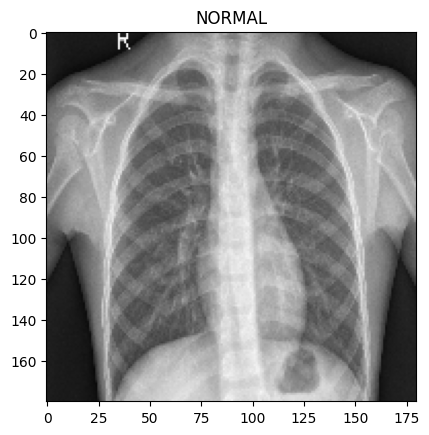

In [21]:
for image, label in test_ds.take(1):
    plt.imshow(image[0] / 255.0)
    plt.title(CLASS_NAMES[label[0].numpy()])

prediction = model.predict(test_ds.take(1))[0]
scores = [1 - prediction, prediction]

for score, name in zip(scores, CLASS_NAMES):
    print("This image is %.2f percent %s" % ((100 * score), name))

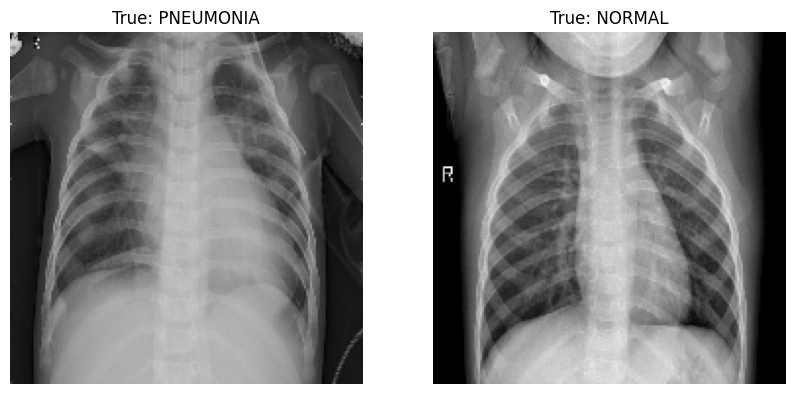

1/1 [==============================] - 0s 433ms/step
This image is 0.01 percent NORMAL
This image is 99.99 percent PNEUMONIA
This image is 99.99 percent NORMAL
This image is 0.01 percent PNEUMONIA


In [22]:
import tensorflow as tf
import matplotlib.pyplot as plt

# Class names for visualization
CLASS_NAMES = ["NORMAL", "PNEUMONIA"]

# Function to display images and predictions
def display_images_with_predictions(test_ds, model):
    # Shuffle the dataset to get random samples
    test_ds = test_ds.shuffle(10000)

    # Get two batches of images and labels from the test dataset
    for (image1, label1), (image2, label2) in zip(test_ds.take(1), test_ds.skip(1).take(1)):
        # Display the images side by side
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))

        # Normalize the images for display
        axes[0].imshow(image1[0] / 255.0)
        axes[0].set_title(f"True: {CLASS_NAMES[label1[0].numpy()]}")
        axes[0].axis('off')

        axes[1].imshow(image2[0] / 255.0)
        axes[1].set_title(f"True: {CLASS_NAMES[label2[0].numpy()]}")
        axes[1].axis('off')

        plt.show()

        # Make predictions
        prediction1 = model.predict(tf.expand_dims(image1[0], axis=0))[0][0]
        prediction2 = model.predict(tf.expand_dims(image2[0], axis=0))[0][0]

        scores1 = [1 - prediction1, prediction1]
        scores2 = [1 - prediction2, prediction2]

        # Print the predictions
        for score, name in zip(scores1, CLASS_NAMES):
            print(f"This image is {score * 100:.2f} percent {name}")

        for score, name in zip(scores2, CLASS_NAMES):
            print(f"This image is {score * 100:.2f} percent {name}")

        break

# Example of creating the test dataset (you need to replace this with your actual dataset loading code)
# Assuming you already have test_ds created as shown in the previous explanations
test_images = tf.data.TFRecordDataset(
    "gs://download.tensorflow.org/data/ChestXRay2017/test/images.tfrec"
)
test_paths = tf.data.TFRecordDataset(
    "gs://download.tensorflow.org/data/ChestXRay2017/test/paths.tfrec"
)
test_ds = tf.data.Dataset.zip((test_images, test_paths))

def get_label(file_path):
    parts = tf.strings.split(file_path, "/")
    return 1 if parts[-2] == "PNEUMONIA" else 0

def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3)
    return tf.image.resize(img, IMAGE_SIZE)

def process_path(image, path):
    label = get_label(path)
    img = decode_img(image)
    return img, label

AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 25
IMAGE_SIZE = [180, 180]

test_ds = test_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

# Example model (replace this with your actual model)
# model = ... (Assume you have your model already defined and trained)

# Display images and predictions
display_images_with_predictions(test_ds, model)